In [5]:
from pde import DiffusionPDE, ScalarField, UnitGrid, CartesianGrid, MemoryStorage, PDE, movie, plot_kymograph
import numpy as np
import gc

In [7]:
def generate_string(params, opp='cos', var='x'):
    string = ""
    for idx, param in enumerate(params):
        if(idx == 0):
            string += f"{param}*{opp}({var})"
        else:
            string += f"+{param}*{opp}({var})"
    return string

In [8]:
def generate_example(cos_x_params, sin_x_params, cos_y_params, sin_y_params, diffusivity=0.4):
    grid = UnitGrid([64, 64], periodic=[True, True])
    # get random init weights
    cos_x_inital_weights = [np.random.normal(mu, sigma) for (mu, sigma) in cos_x_params]
    sin_x_inital_weights = [np.random.normal(mu, sigma) for (mu, sigma) in sin_x_params]
    cos_y_inital_weights = [np.random.normal(mu, sigma) for (mu, sigma) in cos_y_params]
    sin_y_inital_weights = [np.random.normal(mu, sigma) for (mu, sigma) in sin_y_params]
    # get the string equation
    init_equation = generate_string(cos_x_inital_weights)
    init_equation += '+' + generate_string(sin_x_inital_weights, opp='sin')
    init_equation += '+' + generate_string(cos_y_inital_weights, var='y')
    init_equation += '+' + generate_string(sin_y_inital_weights, opp='sin', var='y')
    # generate the inital state
    state = ScalarField.from_expression(grid, init_equation)
    bc_x = 'periodic' #{"derivative": 0.0}
    bc_y = 'periodic' #{"derivative": 0.0}
    eq = DiffusionPDE(diffusivity=diffusivity, bc=[bc_x, bc_y])
    # get examples
    example = []
    storage = MemoryStorage()
    results = eq.solve(state, t_range=4, dt=0.1, tracker=["progress", storage.tracker(0.1)])
    del grid
    del state
    del eq
    gc.collect()

    for time_step, field in storage.items():
        example.append(np.expand_dims(field.data, axis=0))
    example = np.expand_dims(np.concatenate(example.copy()), axis=0)

    del storage
    del results
    gc.collect()
    return example

cos_x_params = [(1.0, 1.0),(-0.75, 1.0)]
sin_x_params = [(-0.25, 1.0),(0.0, 0.1),(2.0, 1.0)]
cos_y_params = [(0.0, 0.1),(0.0, 0.1),(0.0, 0.01),(3.0, 1.0)]
sin_y_params = [(2.0, 1.25),]

def get_diffusivity_sample():
    diffusivity = np.random.normal(loc=0.4, scale=0.1)
    diffusivity = max(diffusivity, 0.2)
    diffusivity = min(diffusivity, 0.6)
    return diffusivity

train_data = []
for train_idx in range(50):
    diffusivity = get_diffusivity_sample()
    train_data.append(generate_example(cos_x_params, sin_x_params, cos_y_params, sin_y_params, diffusivity=diffusivity))
train_data = np.concatenate(train_data)

val_data = []
for val_idx in range(8):
    diffusivity = get_diffusivity_sample()
    val_data.append(generate_example(cos_x_params, sin_x_params, cos_y_params, sin_y_params, diffusivity=diffusivity))
val_data = np.concatenate(val_data)

test_data = []
for test_idx in range(8):
    diffusivity = get_diffusivity_sample()
    test_data.append(generate_example(cos_x_params, sin_x_params, cos_y_params, sin_y_params, diffusivity=diffusivity))
test_data = np.concatenate(test_data)

with open('heat_sinusoidal_init_varying_diffusivity_periodic_boundaries.npy', mode='wb') as f:
    np.save(f, train_data, allow_pickle=True)
    np.save(f, val_data, allow_pickle=True)
    np.save(f, test_data, allow_pickle=True)

train_data.shape, val_data.shape, test_data.shape

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/4.0 [00:00<?, ?it/s]

((50, 40, 64, 64), (8, 40, 64, 64), (8, 40, 64, 64))

  0%|          | 0/4.0 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

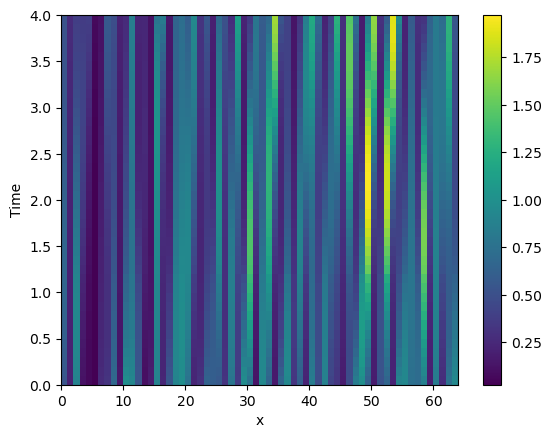

In [7]:
grid = UnitGrid([64, 64], periodic=[True, True])
state = ScalarField.random_uniform(grid, 0.0, 1.0)

nu = 0.1 / np.pi
eq = PDE(
    {'u':f'{nu} * (laplace(u) + laplace(u)) - u * (getx(gradient(u)) + gety(gradient(u)))'},
    user_funcs={'getx':lambda arr: arr[0], 'gety':lambda arr: arr[1]}
)

example = []
storage = MemoryStorage()
results = eq.solve(state, t_range=2, dt=0.1, tracker=["progress", storage.tracker(0.1)])

movie(storage, filename="example_burgers.mov")
plot_kymograph(storage)


In [ ]:

grid = UnitGrid([64, 64], periodic=[False, True])  # generate grid
state = ScalarField.random_uniform(grid, 0.0, 1.0)  # generate initial condition

bc_x_left = {"derivative": 0.0}
bc_x_right = {"value": 0.0}
bc_x = [bc_x_left, bc_x_right]
bc_y = "periodic"

eq = DiffusionPDE(diffusivity=0.4, bc=[bc_x, bc_y])

storage = MemoryStorage()
results = eq.solve(state, t_range=10, dt=0.1, tracker=["progress", storage.tracker(0.1)])

In [ ]:
import numpy as np
np.pi * 2

In [ ]:
def generate_string(params, opp='cos', var='x'):
    string = ""
    for idx, param in enumerate(params):
        if(idx == 0):
            string += f"{param}*{opp}({var})"
        else:
            string += f"+{param}*{opp}({var})"
    return string

In [ ]:
def generate_unit_grid(x_dims, y_dims, x_periodic=False, y_periodic=False):
    grid = UnitGrid([x_dims, y_dims], periodic=[x_periodic, y_periodic])
    return grid

def generate_init_field_from_eq(grid, equation):
    state = ScalarField.from_expression(grid, equation)
    return state

def generate_init_field_from_random_uniform(grid, lower, upper):
    state = ScalarField.random_uniform(grid, 0.0, 1.0)
    return state

def generate_init_field_from_random_normal(grid, mu, sigma):
    state = ScalarField.random_normal(grid, mean=mu, scaling=sigma)
    return state

In [ ]:
def generate_boundary_conditions()

In [ ]:
from pde import DiffusionPDE, ScalarField, UnitGrid, CartesianGrid, MemoryStorage

grid = UnitGrid([64, 64], periodic=[False, True])  # generate grid
state = ScalarField.from_expression(grid, "0.5*cos(x)-0.25*cos(y)")  # generate initial condition

bc_x_left = {"derivative": 0.0}
bc_x_right = {"value": 0.0}
bc_x = [bc_x_left, bc_x_right]
bc_y = "periodic"

eq = DiffusionPDE(diffusivity=0.4, bc=[bc_x, bc_y])

storage = MemoryStorage()
results = eq.solve(state, t_range=10, dt=0.1, tracker=["progress", storage.tracker(0.1)])

In [ ]:
for time, field in storage.items():
    print(time, field)

In [ ]:
MemoryStorage?

In [ ]:
results = eq.solve(state, t_range=2, dt=0.1)
results

In [ ]:
results1

In [ ]:
results2

In [ ]:

# set boundary conditions `bc` for all axes
bc_x_left = {"derivative": 0.1}
bc_x_right = {"value": "sin(y / 2)"}
bc_x = [bc_x_left, bc_x_right]
bc_y = "periodic"
eq = DiffusionPDE(bc=[bc_x, bc_y])

result = eq.solve(state, t_range=10, dt=0.005)
# results
result

In [ ]:
import autograd.numpy as np
from autograd import grad, hessian

In [ ]:
def init_conditions(x, y):
    t = np.cos(x) + np.cos(y)
    return t

In [ ]:
grad_init = hessian(init_conditions)
grad_init(0.0, 0.0)

In [ ]:
import numpy as np

In [ ]:
x = np.linspace(start=0, stop=1, num=128)
y = np.linspace(start=0, stop=1, num=128)
x, y = np.meshgrid(x, y)

In [ ]:
x, y = np.meshgrid()

In [ ]:
x = np.random.uniform(low=0, high=1, size=100)
x

In [ ]:
def step_in_time(x):
    

In [ ]:
def next_(u):
    0.4 * (
        np.roll(u, 1, axis=0) + 
        np.roll(u, -1, axis=0) + 
        np.roll(u, 1, axis=1) + 
        np.roll(u, -1, axis=1) -
        4 * u
    ) + u
    

In [ ]:
x = torch.tensor(np.pi / 4.1, requires_grad=True) #np.linspace(start=0, stop=2*np.pi, num=100), requires_grad=True)
y = torch.cos(x)
y.backward()
x.grad

In [ ]:
import deepxde as dde

In [ ]:
ALPHA = 0.01

def pde(X, T):
    dT_xx = dde.grad.hessian(T, X, j=0)
    dT_yy = dde.grad.hessian(T, X, j=1)
    dT_t = dde.grad.jacobian(T, X, j=2)
    return dT_t - (ALPHA * (dT_xx + dT_yy))

In [ ]:
# Define the initial condition
def initial_condition(x, y):
    return np.exp(-(x**2 + y**2))

In [ ]:
# Define the geometry
geom = dde.geometry.Rectangle([0, 0], [1, 1])
geom

In [ ]:
timedomain = dde.geometry.TimeDomain(0, 50)
timedomain

In [ ]:
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
geomtime

In [ ]:
T0 = 300
Tinit = 1000

def func(x):
    return np.ones((len(x),1), dtype=np.float32)*T0

def func_n(x):
    return np.zeros((len(x),1), dtype=np.float32)

def func_init(x):
    return np.ones((len(x),1), dtype=np.float32)*Tinit

In [ ]:
def boundary_x_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_x_r(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

def boundary_y_b(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0)

def boundary_y_u(x, on_boundary):
    return on_boundary and np.isclose(x[1], 1)

In [ ]:
bc_x_l = dde.DirichletBC(geomtime, func, boundary_x_l)
bc_x_r = dde.DirichletBC(geomtime, func, boundary_x_r)
bc_y_b = dde.DirichletBC(geomtime, func, boundary_y_b)
bc_y_u = dde.NeumannBC(geomtime, func_n, boundary_y_u)
ic = dde.IC(geomtime, func_init, lambda _, on_initial: on_initial)

In [ ]:
data = dde.data.TimePDE(
    geomtime,
    pde, 
    [bc_x_l, bc_x_r, bc_y_b, bc_y_u, ic],
    num_domain=1000,
    num_boundary=1000,
    num_initial=1000,
)

In [ ]:
data.train_next_batch()
data.


In [ ]:
data.test()

In [ ]:
net = dde.nn.FNN([1000], "tanh", "Glorot normal")

In [ ]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

In [ ]:
losshistory, train_state = model.train(iterations=20000)

In [ ]:
data.update()

In [ ]:
data.get_x()

In [ ]:

initial_condition_data = dde.data.PDE(geom, heat_equation, lambda _, on_initial: initial_condition(*on_initial), num_domain=1000, num_boundary=100)

In [ ]:
x = np.linspace(start=0, stop=2*np.pi, num=100)
y = np.cos(x)

dde.grad.jacobian(x, y)